<a href="https://colab.research.google.com/github/valerio-unifei/ECOM09A/blob/main/ECOM09A_2024_1_Atividade_2_Etapa_1_7classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECOM09A Atividade 2 Etapa 1

(10/05/2024) Realizar o procedimento do notebook:

https://www.kaggle.com/code/marlesson/vocabulary-analysis-word2vec


## Dataset

In [2]:
import os
from google.colab import files, userdata

if not os.path.exists('/content/articles.csv'):
  if not os.path.exists('kaggle.json'):
    try:
      kaggle_key = userdata.get('kaggle_key')
      open('kaggle.json','w').write(kaggle_key)
    except:
      files.upload()

  !pip install -q kaggle

  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !rm kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download 'marlesson/news-of-the-site-folhauol'
  !unzip -qq news-of-the-site-folhauol.zip
  !rm news-of-the-site-folhauol.zip

Dataset URL: https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol
License(s): CC0-1.0
100% 187M/187M [00:07<00:00, 37.5MB/s]
100% 187M/187M [00:07<00:00, 25.6MB/s]


### Carregando os artigos do jornal

In [3]:
import pandas as pd
df_folha = pd.read_csv('articles.csv',encoding="utf8")
df_folha.drop(["title","date","subcategory","link"],axis=1,inplace=True)
df_folha.drop_duplicates(subset=["text"],inplace=True)
df_folha.dropna(inplace=True)
df_folha.reset_index(drop=True,inplace=True)
df_folha = df_folha[df_folha['category'].isin(list(df_folha['category'].value_counts()[:7].index))]

targets, class_names = pd.factorize(df_folha['category'],sort=True)
samples = df_folha['text'].values

df_folha.drop(["category"],axis=1,inplace=True)
df_folha['target'] = targets
display(df_folha.head())
del df_folha

<ipython-input-3-15573e561a39>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_folha.drop(["category"],axis=1,inplace=True)
<ipython-input-3-15573e561a39>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_folha['target'] = targets


,text,target
0,Com a possibilidade de uma condenação impedir ...,6
1,"Para Oumou Sangaré, cantora e ativista malines...",3
2,Três reportagens da Folha foram vencedoras do ...,6
3,A Disney divulgou na noite desta segunda-feira...,3
4,"O CBSS, banco da holding Elopar dos sócios Bra...",4


## Realizando treinamento com Sklearn ML Clássico (fora do enunciado)

In [4]:
import numpy as np
# Misturando
rng = np.random.RandomState(42)
rng.shuffle(samples)
rng = np.random.RandomState(42) # faz a mesma mistura do anterior
rng.shuffle(targets)
# extraindo treinamento e validacao
parte_analisada = min(5000,len(samples)) # problemas de RAM
val_split = 0.2
val_num = int(val_split * parte_analisada)

samples_train = samples[:parte_analisada-val_num]
y_train = targets[:parte_analisada-val_num]

samples_test = samples[parte_analisada-val_num:parte_analisada]
y_test = targets[parte_analisada-val_num:parte_analisada]

samples_train.shape,y_train.shape, samples_test.shape, y_test.shape

((4000,), (4000,), (1000,), (1000,))

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

cVec = CountVectorizer()
cVec.fit(samples_train)
X_train = cVec.transform(samples_train)
X_test = cVec.transform(samples_test)

tfid = TfidfTransformer()
tfid.fit(X_train)
X_train = tfid.transform(X_train)
X_test = tfid.transform(X_test)

X_train.shape,y_train.shape, X_test.shape, y_test.shape

((4000, 65859), (4000,), (1000, 65859), (1000,))

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, RidgeClassifier

classificador = [
    MultinomialNB(),
    SGDClassifier(random_state=42),
    RidgeClassifier(random_state=42),
]

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score
from tqdm.notebook import tqdm

res = []
for c in tqdm(classificador):
  c.fit(X_train, y_train)
  y_pred = c.predict(X_test)

  dn={
      'metodo':c.__class__.__name__,
      'acurárica':accuracy_score(y_test, y_pred),
      'bal_acc':balanced_accuracy_score(y_test, y_pred),
      'f1':f1_score(y_test, y_pred,average='macro'),
      }
  res.append(dn)

rdf = pd.DataFrame(res)

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
rdf

,metodo,acurárica,bal_acc,f1
0,MultinomialNB,0.688,0.657374,0.675122
1,SGDClassifier,0.869,0.872877,0.869275
2,RidgeClassifier,0.866,0.870690,0.866145


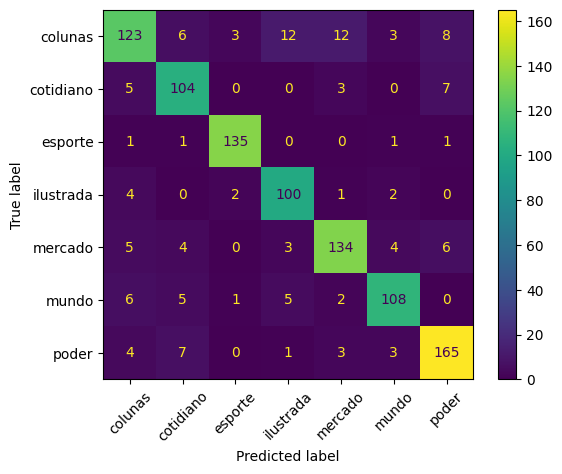

In [9]:
c = SGDClassifier(random_state=42)
c.fit(X_train, y_train)
y_pred = c.predict(X_test)
y_real = y_test

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_real, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)